In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Results

To find out whether asset bubbles are associated with increased inequality, I first explore their correlation structure using Monte Carlo Simulations. This means that I simulate the model $N_{sim} = 500$ times in which the random number generator is initialized with a different seed. 

## Do asset bubbles increase inequality?
To find out, I first study the correlation structure of bubbles and inequality in Monte Carlo Simulations. 

In [14]:
with open('all_many_bubbles_output.json', 'r') as f:
    bubble_data = json.loads(f.read())

In [15]:
runs = len(bubble_data)
runs

28

First, I reorganize the data.

In [16]:
bubble_types = []
bubble_prices = []
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = [] 
horizons = [] 
learning_abilities = [] 
chartist_expectations = [] 
fundamentalist_expectations = []

for r in range(runs):
    if bubble_data[r][1]:
        bubble_types += bubble_data[r][0]
        bubble_prices += bubble_data[r][1]
        wealth_starts += bubble_data[r][2]
        wealth_ends += bubble_data[r][3]
        ginis_ot += bubble_data[r][4]
        palmas_ot += bubble_data[r][5]
        twtws_ot += bubble_data[r][6]
        risk_aversions += bubble_data[r][7]
        horizons += bubble_data[r][8]
        learning_abilities += bubble_data[r][9]
        chartist_expectations += bubble_data[r][10]
        fundamentalist_expectations += bubble_data[r][11]

In [17]:
unique_bubble_types = list(set(bubble_types))
unique_bubble_types

['boom-bust', 'bust-boom', 'bust', 'boom']

Then, I calculate the differences in inequality ratio's for every bubble.

In [18]:
my_indices = [idx for idx, p in enumerate(bubble_prices) if p]

# clean bubble series 
bubble_types = [bubble_types[i] for i in my_indices]
bubble_prices = [bubble_prices[i] for i in my_indices]
wealth_starts = [wealth_starts[i] for i in my_indices]
wealth_ends = [wealth_ends[i] for i in my_indices]
ginis_ot = [ginis_ot[i] for i in my_indices]
palmas_ot = [palmas_ot[i] for i in my_indices]
twtws_ot = [twtws_ot[i] for i in my_indices]

ginis_ot_dif = [g[-1] - g[0] for g in ginis_ot]
palmas_ot_dif = [g[-1] - g[0] for g in palmas_ot]
twtws_ot_dif = [g[-1] - g[0] for g in twtws_ot]

For every bubble, calculate the lenght and magnitude of the bubble.

In [19]:
bubble_lenght = [len(b) for b in bubble_prices]

# if boom or bust, magnitude is price difference 
bubble_magnitude = []
for idx, b_type in enumerate(bubble_types):
    if b_type in ['boom', 'bust']:
        bubble_magnitude.append(abs(bubble_prices[idx][-1] - bubble_prices[idx][0]))
    elif b_type in ['boom-bust', 'bust-boom']:
        bubble_magnitude.append(abs(np.mean(bubble_prices[idx]) - bubble_prices[idx][0]))
    else:
        #print(b_type)
        bubble_magnitude.append(pd.Series(bubble_prices[idx]).std())

In [20]:
# alternatively, just use the std in prices for all bubbles 
bubble_magnitude2 = []
for idx, b_type in enumerate(bubble_types):
    bubble_magnitude2.append(pd.Series(bubble_prices[idx]).std())

In [21]:
bubble_df = pd.DataFrame({'bubble_type': bubble_types, 'magnitude': bubble_magnitude2, 'lenght': bubble_lenght, 
              'gini_diff': ginis_ot_dif, 'palma_diff': palmas_ot_dif, 'twtw_diff': twtws_ot_dif})
bubble_df['const'] = 1
bubble_df['magn_len'] = bubble_df['magnitude'] * bubble_df['lenght']

In [22]:
bubble_df.head()

,bubble_type,magnitude,lenght,gini_diff,palma_diff,twtw_diff,const,magn_len
0,boom-bust,1.278567,7,0.000300,0.002984,0.003403,1,8.949970
1,boom-bust,1.894251,22,0.001042,0.003807,0.017565,1,41.673526
2,boom-bust,5.070751,26,0.001983,0.009473,0.072128,1,131.839532
3,bust-boom,4.080676,31,0.003291,0.019897,0.061842,1,126.500965
4,boom,9.318927,45,0.004013,0.031828,0.128899,1,419.351727


In [23]:
# regres gini_diff, palma_diff & twtw diff on magnitude, lenght & magnitude*lenght
gini_res = sm.OLS(endog=bubble_df['gini_diff'], exog=bubble_df[['const', 'magnitude']], missing='drop').fit()
palma_res = sm.OLS(endog=bubble_df['palma_diff'], exog=bubble_df[['const', 'magnitude']], missing='drop').fit()
twtw_res = sm.OLS(endog=bubble_df['twtw_diff'], exog=bubble_df[['const', 'magnitude']], missing='drop').fit()

In [24]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res, palma_res, twtw_res],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma', '20-20'],
                            info_dict=info_dict,
                            regressor_order=['const', 'magnitude'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                         Table - OLS Regressions
                        Gini              Palma              20-20       
-------------------------------------------------------------------------
const            -0.0014            -0.2111***         -0.7432***        
                 (0.0029)           (0.0672)           (0.2454)          
magnitude        0.0012***          0.0320***          0.1191***         
                 (0.0001)           (0.0026)           (0.0094)          
R-squared        0.7485984273834476 0.8042451190815382 0.8095868131722288
No. observations 40                 40                 40                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## Experiment 1 



In [26]:
NRUNS = 5

In [27]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

Fix the learning ability for a clean experiment.

In [28]:
params['average_learning_ability'] = 0.0

Increment the share of chartists from 0.0 to 100

In [29]:
share_chartists = [x / 100.0 for x in range(0, 102, 2)]

Run model and update share chartists every time

In [ ]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    params['strat_share_chartists'] = share_chartists[seed]
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Structure the data

In [ ]:
ginis = []
palmas = []
twtws = []
asset_price_inflation = []
price_to_div_stdev = []

for idx, traders in enumerate(trdrs):
    #print(t)
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    asset_price_inflation.append(orbs[idx].tick_close_price[-1] - orbs[idx].tick_close_price[0])
    price_to_div_stdev.append((pd.Series(orbs[idx].tick_close_price) / pd.Series(orbs[idx].fundamental[1:])).std())
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    share_top_20 = sum(np.sort(wealth)[int(len(wealth) * 0.8):]) / sum(wealth)
    share_bottom_20 = sum(np.sort(wealth)[:int(len(wealth) * 0.2)]) / sum(wealth)
    twtws.append(share_top_20 / share_bottom_20)
    
    ginis.append(gini(wealth))

In [ ]:
data = pd.DataFrame({'gini': np.log(ginis[1:]), 'palma': np.log(palmas[1:]), 'twtw': np.log(twtws[1:]), 'pd_vol': price_to_div_stdev[1:],
                     'share_chartists': np.log(share_chartists[1:]), 'lin_share_chartists': share_chartists[1:], 'asset_price_infl': asset_price_inflation[1:]})
data['const'] = 1

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

ax1.scatter(range(len(ginis)), ginis)
ax2.scatter(range(len(palmas)), palmas)
ax3.scatter(range(len(twtws)), twtws)

ax3.set_title('Twenty-twenty ratio')
ax2.set_title('Palma ratio')
ax1.set_title('Gini coefficient')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation')

#fig.savefig('gini_palma_twenty_evolution_bubble.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.scatter(range(len(asset_price_inflation)), asset_price_inflation)
ax2.scatter(range(len(price_to_div_stdev)), price_to_div_stdev)


ax1.set_title('asset_price_inflation')
ax2.set_title('price_to_div_stdev')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation')

In [ ]:
gini_res = sm.OLS(endog=data['gini'], exog=data[['const', 'share_chartists']], missing='drop').fit()
palma_res = sm.OLS(endog=data['palma'], exog=data[['const', 'share_chartists']], missing='drop').fit()
twtw_res = sm.OLS(endog=data['twtw'], exog=data[['const', 'share_chartists']], missing='drop').fit()
asset_p_inf_res = sm.OLS(endog=data['asset_price_infl'], exog=data[['const', 'lin_share_chartists']], missing='drop').fit()
pd_stdev_res = sm.OLS(endog=data['pd_vol'], exog=data[['const', 'lin_share_chartists']], missing='drop').fit()

In [ ]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res, palma_res, twtw_res, asset_p_inf_res, pd_stdev_res],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma', '20-20', 'Asset-price inflation', 'Pd-volatility'],
                            info_dict=info_dict,
                            regressor_order=['const', 'share_chartists'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

# Which agents benefit?

Calculate profits for all agents as the differences in wealth.

In [ ]:
# total_strat_weight = trader.var.weight_fundamentalist[-1] + trader.var.weight_chartist[-1]
# c_share_strat = weight_chartist / total_strat_weight


In [25]:
profits = []
real_profits = []
for idx, bubble in enumerate(bubble_types): 
    profits.append((np.array(wealth_ends[idx]) - np.array(wealth_starts[idx])) / np.array(wealth_starts[idx]))
    real_profits.append(np.array(wealth_ends[idx]) - np.array(wealth_starts[idx]))

Profits contains profits of all agents for every bubble episode. What I need is every individual profit with the bubble type next to it.

In [26]:
all_profits = []
all_real_profits = []
all_bubbles = []
c_share_strat = []
learn_ab = []
hors = []
rav = []
w_starts = []
for idx, p in enumerate(profits):
    all_profits += list(p)
    all_real_profits += list(real_profits[idx])
    all_bubbles += [bubble_types[idx] for l in p]
    learn_ab += learning_abilities[idx]
    hors += horizons[idx]
    rav += risk_aversions[idx]
    w_starts += wealth_starts[idx]
    c_share_strat += [np.mean(c_exp) / (np.mean(c_exp) + np.mean(f_exp)) for c_exp, f_exp in zip(chartist_expectations[idx], fundamentalist_expectations[idx])]

In [27]:
redistr_df = pd.DataFrame({'wealth_change': all_profits, 'real_wealth_ch': all_real_profits, 'bubble_type': all_bubbles, 'risk_av': rav, 
              'horizon': hors, 'learning': learn_ab, 'c_share_strat': c_share_strat, 'wealth_start': w_starts})
redistr_df['abs_profit'] = redistr_df['wealth_change'].abs()
redistr_df['positive_profit'] = redistr_df['wealth_change'] > 0
redistr_df['const'] = 1

In [28]:
redistr_df = pd.get_dummies(redistr_df, columns = ['positive_profit'])

In [29]:
redistr_df['wealth_start_positive'] = redistr_df['positive_profit_True'] * redistr_df['wealth_start']
redistr_df['wealth_start_negative'] = redistr_df['positive_profit_False'] * redistr_df['wealth_start']

In [46]:
redistr_df.head(10)

,wealth_change,real_wealth_ch,bubble_type,risk_av,horizon,learning,c_share_strat,wealth_start,abs_profit,const,positive_profit_False,positive_profit_True,wealth_start_positive,wealth_start_negative
0,0.010251,49.179709,boom-bust,0.789059,43,0.118615,0.366942,4797.418459,0.010251,1,0,1,4797.418459,0.000000
1,0.000000,0.000000,boom-bust,1.287427,124,0.298143,0.508778,5973.838099,0.000000,1,1,0,0.000000,5973.838099
2,0.010559,100.408572,boom-bust,1.140765,19,0.724937,0.542054,9509.291513,0.010559,1,0,1,9509.291513,0.000000
3,0.010111,122.949272,boom-bust,0.924572,86,0.461712,0.503843,12159.393139,0.010111,1,0,1,12159.393139,0.000000
4,0.010464,127.047581,boom-bust,1.139736,115,0.777666,0.530438,12141.839896,0.010464,1,0,1,12141.839896,0.000000
5,-0.000988,-22.527102,boom-bust,0.835647,69,0.650943,0.494503,22797.145270,0.000988,1,1,0,0.000000,22797.145270
6,0.009946,173.967690,boom-bust,1.256892,150,0.306482,0.816651,17491.432077,0.009946,1,0,1,17491.432077,0.000000
7,0.000000,0.000000,boom-bust,1.204918,15,0.498636,0.472196,14210.489080,0.000000,1,1,0,0.000000,14210.489080
8,0.010433,57.376327,boom-bust,1.723577,190,0.303485,0.401522,5499.348728,0.010433,1,0,1,5499.348728,0.000000
9,0.000000,0.000000,boom-bust,1.392093,94,0.034381,0.244219,9515.871117,0.000000,1,1,0,0.000000,9515.871117


## Scatter plot

Relative and absolute wealth changes

Text(0, 0.5, 'wealth_start')

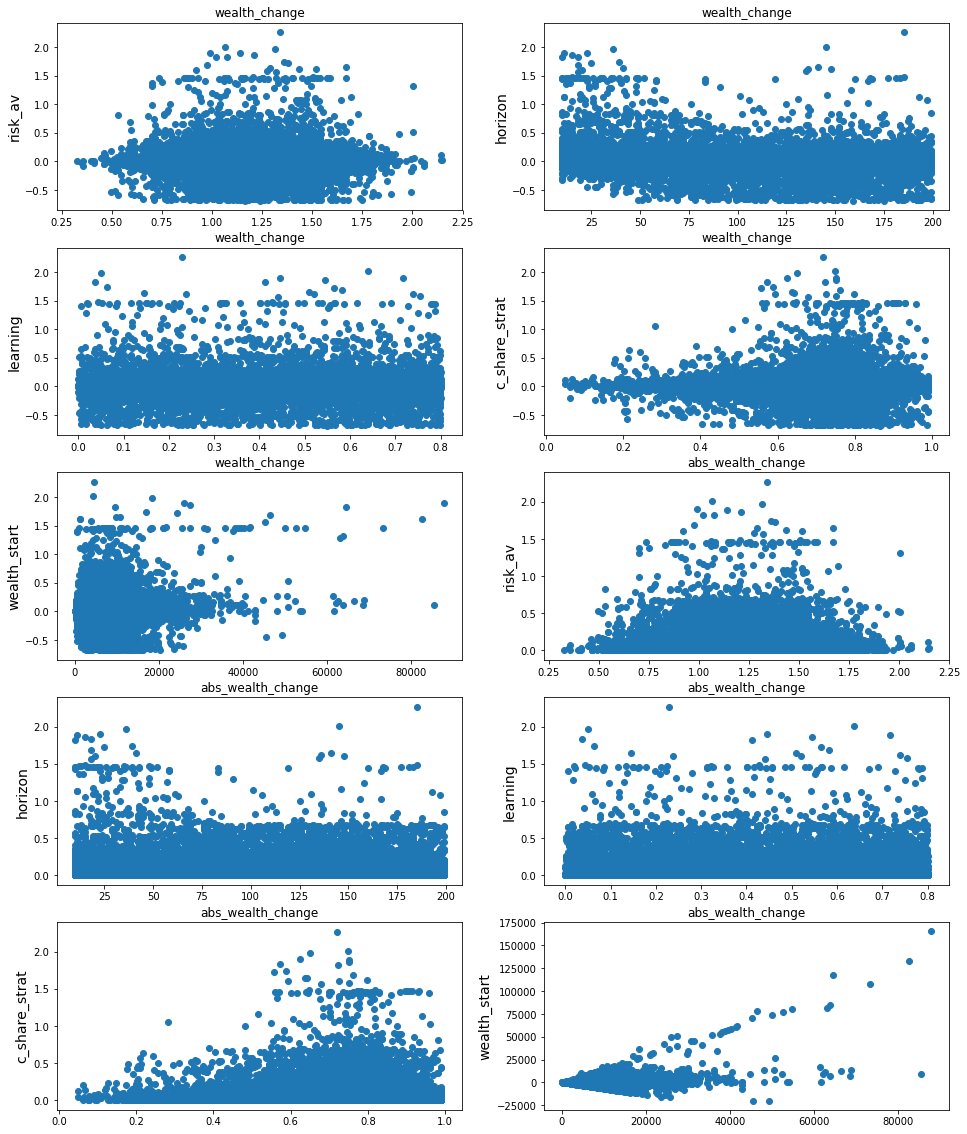

In [44]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=[16,20])

ax1.scatter(redistr_df['risk_av'], redistr_df['wealth_change'])
ax2.scatter(redistr_df['horizon'], redistr_df['wealth_change'])
ax3.scatter(redistr_df['learning'], redistr_df['wealth_change'])
ax4.scatter(redistr_df['c_share_strat'], redistr_df['wealth_change']) #TODO have a fraction here of chart vs fund
ax5.scatter(redistr_df['wealth_start'], redistr_df['wealth_change'])
#ax6.scatter(redistr_df['wealth_start_positive'], redistr_df['real_wealth_ch'])

ax6.scatter(redistr_df['risk_av'], redistr_df['abs_profit'])
ax7.scatter(redistr_df['horizon'], redistr_df['abs_profit'])
ax8.scatter(redistr_df['learning'], redistr_df['abs_profit'])
ax9.scatter(redistr_df['c_share_strat'], redistr_df['abs_profit']) #TODO have a fraction here of chart vs fund
ax10.scatter(redistr_df['wealth_start'], redistr_df['abs_profit'])


ax1.set_title('wealth_change')
ax2.set_title('wealth_change')
ax3.set_title('wealth_change')
ax4.set_title('wealth_change')
ax5.set_title('wealth_change')

ax6.set_title('abs_wealth_change')
ax7.set_title('abs_wealth_change')
ax8.set_title('abs_wealth_change')
ax9.set_title('abs_wealth_change')
ax10.set_title('abs_wealth_change')

ax1.set_ylabel('risk_av', fontsize=14)
ax2.set_ylabel('horizon', fontsize=14)
ax3.set_ylabel('learning', fontsize=14)
ax4.set_ylabel('c_share_strat', fontsize=14)
ax5.set_ylabel('wealth_start', fontsize=14)
ax6.set_ylabel('risk_av', fontsize=14)
ax7.set_ylabel('horizon', fontsize=14)
ax8.set_ylabel('learning', fontsize=14)
ax9.set_ylabel('c_share_strat', fontsize=14)
ax10.set_ylabel('wealth_start', fontsize=14)

In [47]:
# 2 regression
reg1 = sm.OLS(endog=redistr_df['wealth_change'], exog=redistr_df[['const', 'risk_av', 'horizon', 'learning', 'c_share_strat', 'wealth_start']], missing='drop').fit()
reg2 = sm.OLS(endog=redistr_df['abs_profit'], exog=redistr_df[['const', 'risk_av', 'horizon', 'learning', 'c_share_strat', 'wealth_start']], missing='drop').fit()
reg3 = sm.OLS(endog=redistr_df['real_wealth_ch'], exog=redistr_df[['const', 'risk_av', 'horizon', 'learning', 'c_share_strat', 'wealth_start']], missing='drop').fit()

In [48]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[reg1, reg2, reg3],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['% Profit', '% Profit abs', 'wealth change'],
                            info_dict=info_dict,
                            regressor_order=['const', 'risk_av', 'horizon', 'learning', 'c_share_strat', 'wealth_start'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                          Table - OLS Regressions
                       % Profit          % Profit abs       wealth change   
----------------------------------------------------------------------------
const            -0.0051             -0.0929***          -1815.9511***      
                 (0.0096)            (0.0082)            (165.4380)         
risk_av          0.0005              -0.0045             59.6801            
                 (0.0055)            (0.0047)            (93.8139)          
horizon          -0.0004***          -0.0000             -2.9190***         
                 (0.0000)            (0.0000)            (0.4199)           
learning         -0.0058             -0.0202***          -182.5359*         
                 (0.0057)            (0.0049)            (98.0535)          
c_share_strat    0.0372***           0.2762***           1045.6800***       
                 (0.0091)            (0.0078)            (156.5294)         
wealth_start     0.0000***